# Image blending using pyramid

In [11]:
from skimage.io import imread, imshow
from skimage.filters import gaussian
from numpy.fft import fft2, fftshift, ifft2
from skimage import img_as_float, img_as_ubyte, transform
import numpy as np
import matplotlib.pyplot as plt
# from skimage.transform import fftshift
%matplotlib inline

In [12]:
img1 = imread('i1.jpg')
img2 = imread('i2.jpg')
if img1.shape[0] != img2.shape[0] & img1.shape[1] != img2.shape[1]:
    print('ERROR! Image shapes do not equal')

#Разделение на каналы
R1 = img1[:, :, 0]
G1 = img1[:, :, 1]
B1 = img1[:, :, 2]
R2 = img2[:, :, 0]
G2 = img2[:, :, 1]
B2 = img2[:, :, 2]

#Маска
#mask = np.zeros((img1.shape[0], img1.shape[1]))
#for i in range(0, img1.shape[1]):
#    for j in range(0, img1.shape[0] // 2 + 1):
#        mask[i, j] = 1
#reversed_mask = 1 - mask

#Маска 2
mask = imread('mask.jpg', as_grey = True)
for i in range(0, mask.shape[1]):
    for j in range(0, mask.shape[0]):
        if mask[i, j] > 0.5:
            mask[i, j] = 1
        else:
            mask[i, j] = 0
reversed_mask = 1 - mask

In [13]:
#Пирамида Гаусса
def build_gauss_pyramid(img, sigma, n_layers):
    i1 = fft2(img)
    arr = np.zeros(i1.shape)
    arr[np.int(np.floor(i1.shape[0] // 2)), np.int(np.floor(i1.shape[1] // 2))] = 1
    arr2 = gaussian(arr, sigma = sigma)
    gfilt = fft2(arr2)
    imgs = []
    fouries = []
    imgs.append(img)
    fouries.append(i1)
    for i in range(1, n_layers + 1):
        i1 = abs(gfilt) * i1
        fouries.append(i1)
        imgs.append(abs(ifft2(i1)))
    return imgs, fouries

#Пирамида Лапласа
def build_laplas_pyramid(img, sigma, n_layers):
    imgs, fouries = build_gauss_pyramid(img, sigma, n_layers)
    fouries_lap = []
    i2 = fft2(img)
    nex = i2 - fouries[1]
    fouries_lap.append(nex)
    imgs[0] = abs(ifft2(nex))
    for i in range(2, n_layers + 1):
        nex2 = fouries[i - 1] - fouries[i]
        fouries_lap.append(nex2)
        imgs[i] = abs(ifft2(nex2))
    return imgs, fouries_lap

In [14]:
layers = 5 #Количество слоев пирамид
sigma = 5 #Размер ядра

#Пирамоды масок
imgsm1_gau, fouriesm1_gau = build_gauss_pyramid(mask, sigma, layers)
imgsm2_gau, fouriesm2_gau = build_gauss_pyramid(reversed_mask, sigma, layers)

#Пирамиды красного канала
R1_gau, R1f_gau = build_gauss_pyramid(R1, sigma, layers)
R1_lap, R1f_lap = build_laplas_pyramid(R1, sigma, layers)

R2_gau, R2f_gau = build_gauss_pyramid(R2, sigma, layers)
R2_lap, R2f_lap = build_laplas_pyramid(R2, sigma, layers)

#Пирамиды зеленого канала
G1_gau, G1f_gau = build_gauss_pyramid(G1, sigma, layers)
G1_lap, G1f_lap = build_laplas_pyramid(G1, sigma, layers)

G2_gau, G2f_gau = build_gauss_pyramid(G2, sigma, layers)
G2_lap, G2f_lap = build_laplas_pyramid(G2, sigma, layers)

#Пирамиды синего канала
B1_gau, B1f_gau = build_gauss_pyramid(B1, sigma, layers)
B1_lap, B1f_lap = build_laplas_pyramid(B1, sigma, layers)

B2_gau, B2f_gau = build_gauss_pyramid(B2, sigma, layers)
B2_lap, B2f_lap = build_laplas_pyramid(B2, sigma, layers)

#Результирующие пирамиды каналов
R_blend = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
G_blend = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
B_blend = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i in range(0, layers):
    R_blend[i] = (R1_lap[i] * imgsm1_gau[i]) + (R2_lap[i] * imgsm2_gau[i])
    G_blend[i] = (G1_lap[i] * imgsm1_gau[i]) + (G2_lap[i] * imgsm2_gau[i])
    B_blend[i] = (B1_lap[i] * imgsm1_gau[i]) + (B2_lap[i] * imgsm2_gau[i])

#Результирующие каналы
RB = np.sum(R_blend, axis=0)
GB = np.sum(G_blend, axis=0)
BB = np.sum(B_blend, axis=0)

#Проверка на выход за границы
RB[RB < 0] = 0
RB[RB > 255] = 255
RB = RB.astype(np.uint8)
 
GB[GB < 0] = 0
GB[GB > 255] = 255
GB = GB.astype(np.uint8)
 
BB[BB < 0] = 0
BB[BB > 255] = 255
BB = BB.astype(np.uint8)

#Сборка результирующего изображения
RGB_blend = np.dstack([RB, GB, BB])

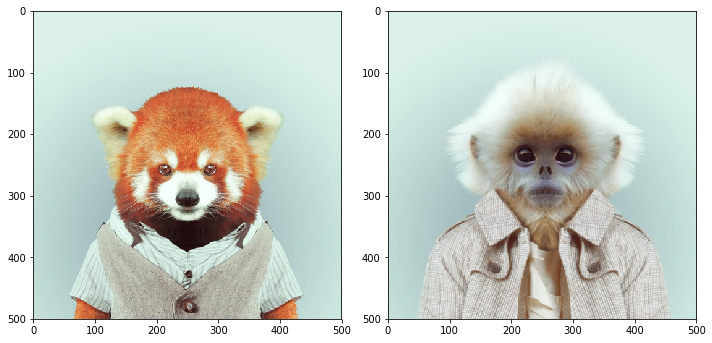

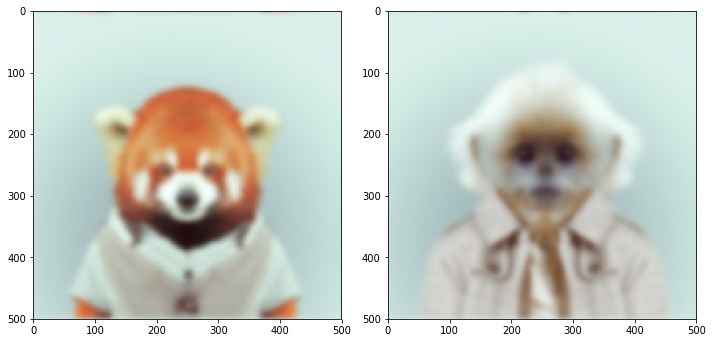

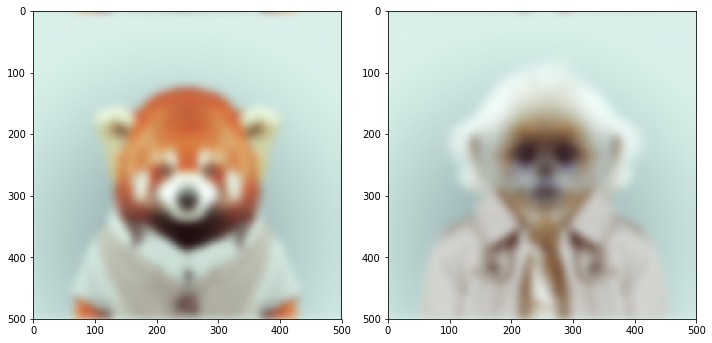

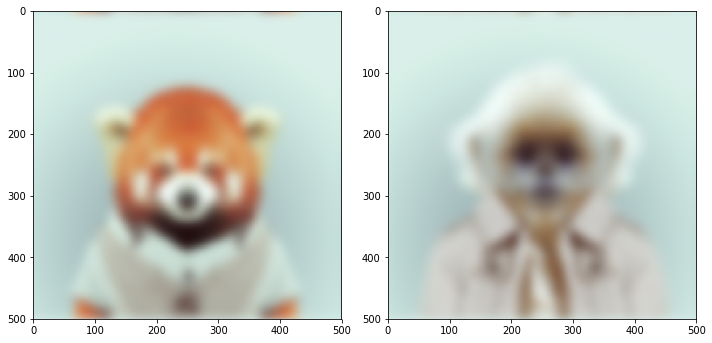

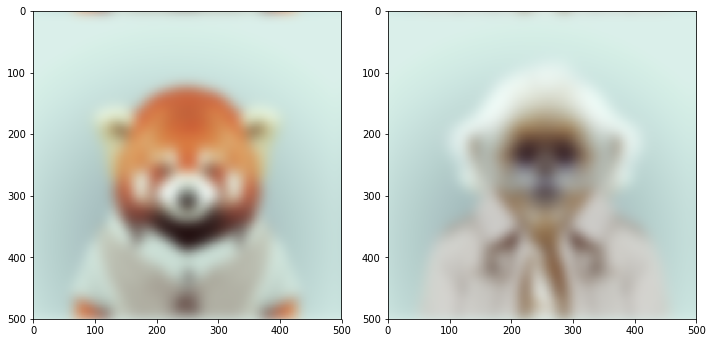

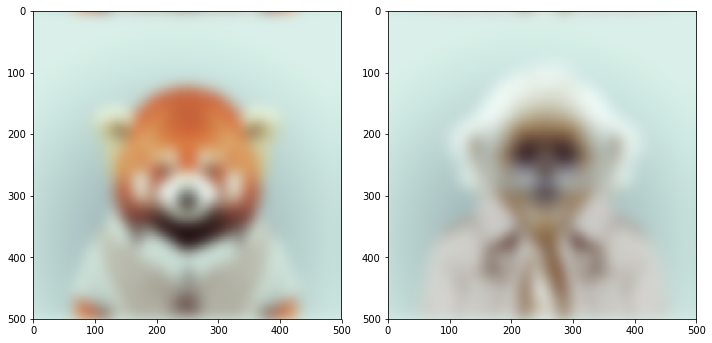

In [15]:
#Пирамиды Гаусса
for i in range(0, layers + 1):
    img1_g = np.dstack([R1_gau[i], G1_gau[i], B1_gau[i]])
    img2_g = np.dstack([R2_gau[i], G2_gau[i], B2_gau[i]])
    
    img1_g[img1_g < 0] = 0
    img1_g[img1_g > 255] = 255
    img1_g = img1_g.astype(np.uint8)
    img2_g[img2_g < 0] = 0
    img2_g[img2_g > 255] = 255
    img2_g = img2_g.astype(np.uint8)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(img1_g)
    plt.subplot(1, 2, 2)
    imshow(img2_g)

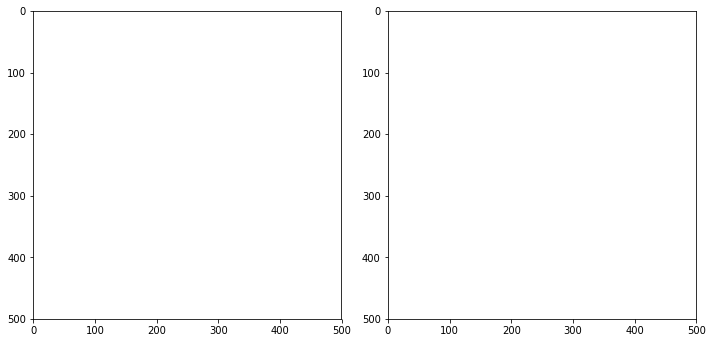

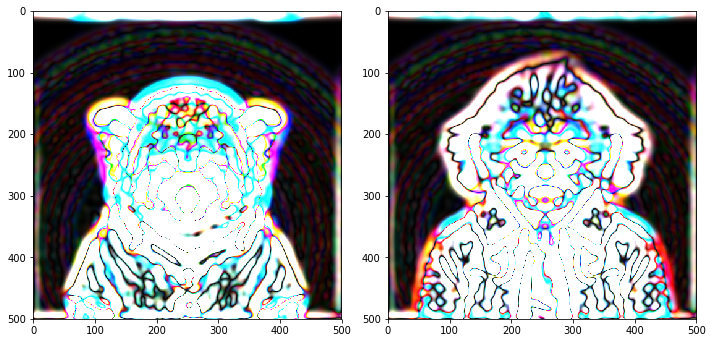

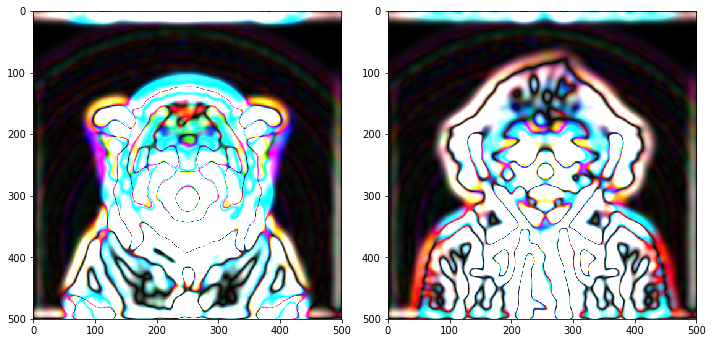

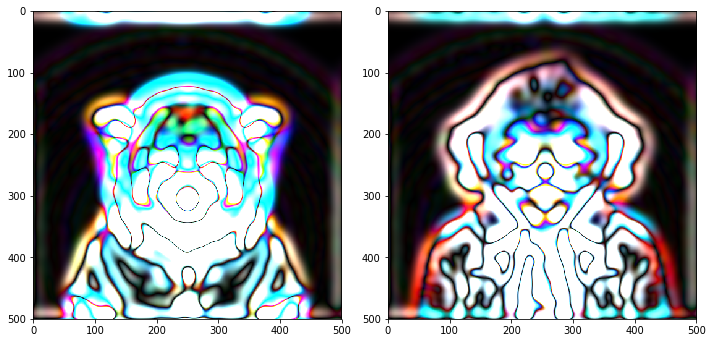

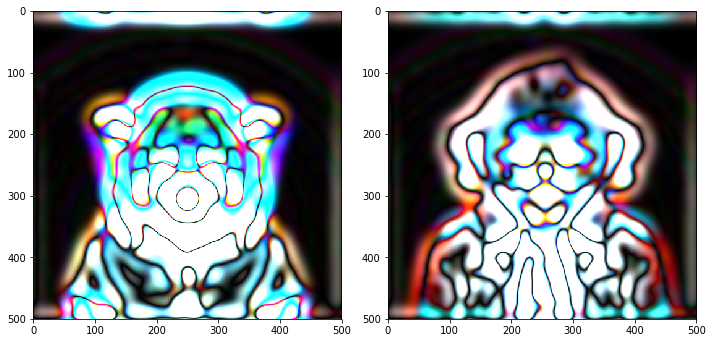

In [16]:
#Пирамиды Лапласа
for i in range(1, layers + 1):
    img1_l = np.dstack([R1_lap[i], G1_lap[i], B1_lap[i]])
    img2_l = np.dstack([R2_lap[i], G2_lap[i], B2_lap[i]])
    
    img1_l[img1_l < 0] = 0
    img1_l[img1_l > 1] = 1
    img2_l[img2_l < 0] = 0
    img2_l[img2_l > 1] = 1

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(img1_l)
    plt.subplot(1, 2, 2)
    imshow(img2_l)

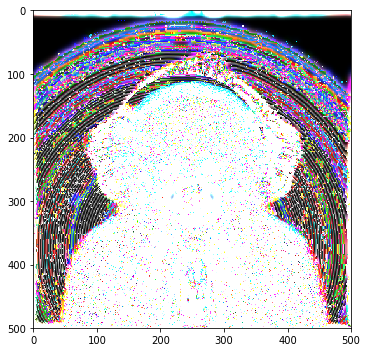

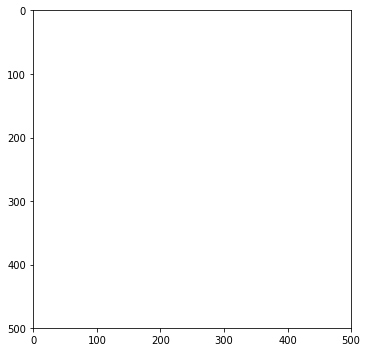

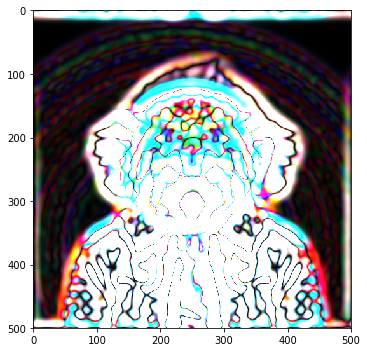

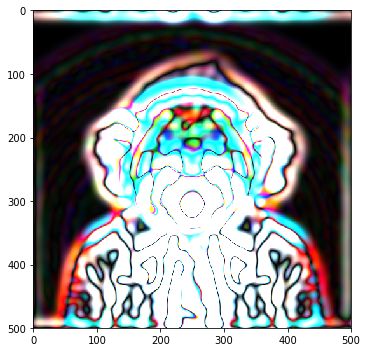

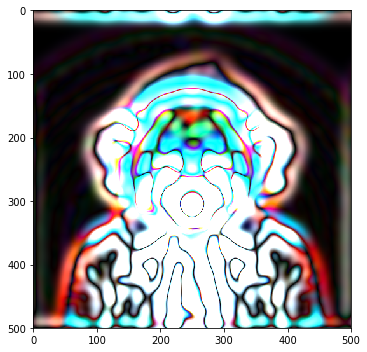

In [17]:
#Результирующая пирамида Лапласа
for i in range(0, layers):
    img_l = np.dstack([R_blend[i], G_blend[i], B_blend[i]])

    img_l[img_l < 0] = 0
    img_l[img_l > 1] = 1

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 1, 1)
    imshow(img_l)

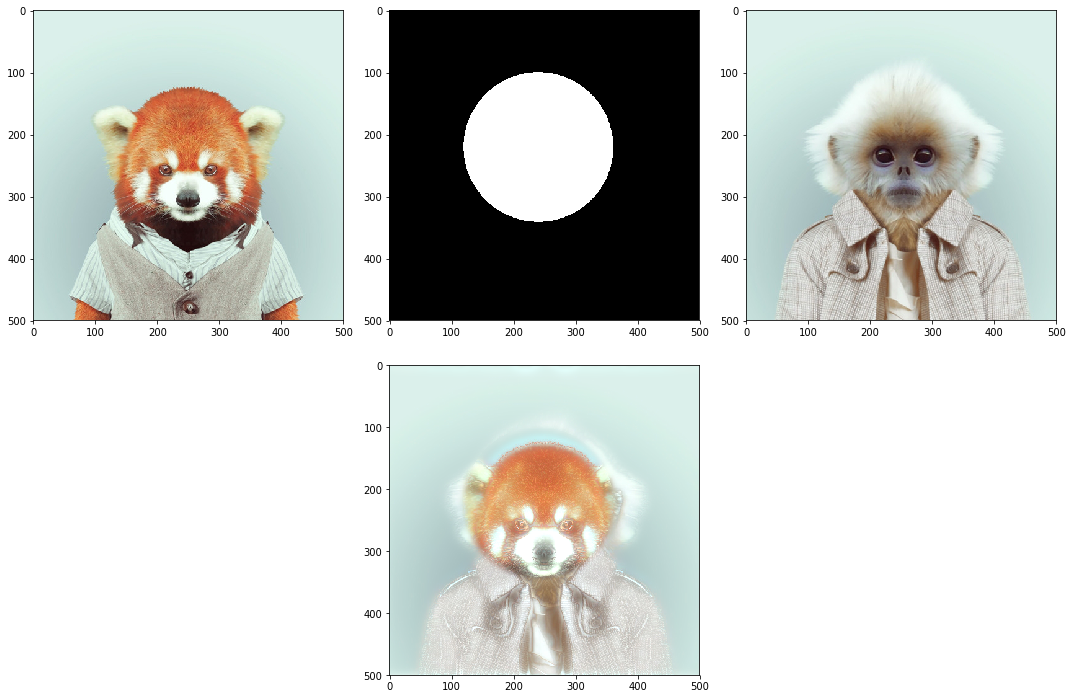

In [18]:
#Результат
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
imshow(img1)
plt.subplot(2, 3, 2)
imshow(mask)
plt.subplot(2, 3, 3)
imshow(img2)
plt.subplot(2, 3, 5)
imshow(RGB_blend)